# TM10007 Assignment template -- ECG data

## Imports

In [6]:
import zipfile
import pandas as pd
import numpy as np

from statistics import median
from scipy.stats import normaltest
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,  average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier



## Data loading

Load the dataset

In [7]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.
The number of samples: 827
The number of columns: 9001


## Nested cross-validation loop

Starting outer fold 1
Univariatiate statistical feature selection performed: 845 features selected.
PCA feature selection performed: 258 features left.
Starting inner fold 1
Best parameters for LogisticRegression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


NameError: name 'y_pred' is not defined

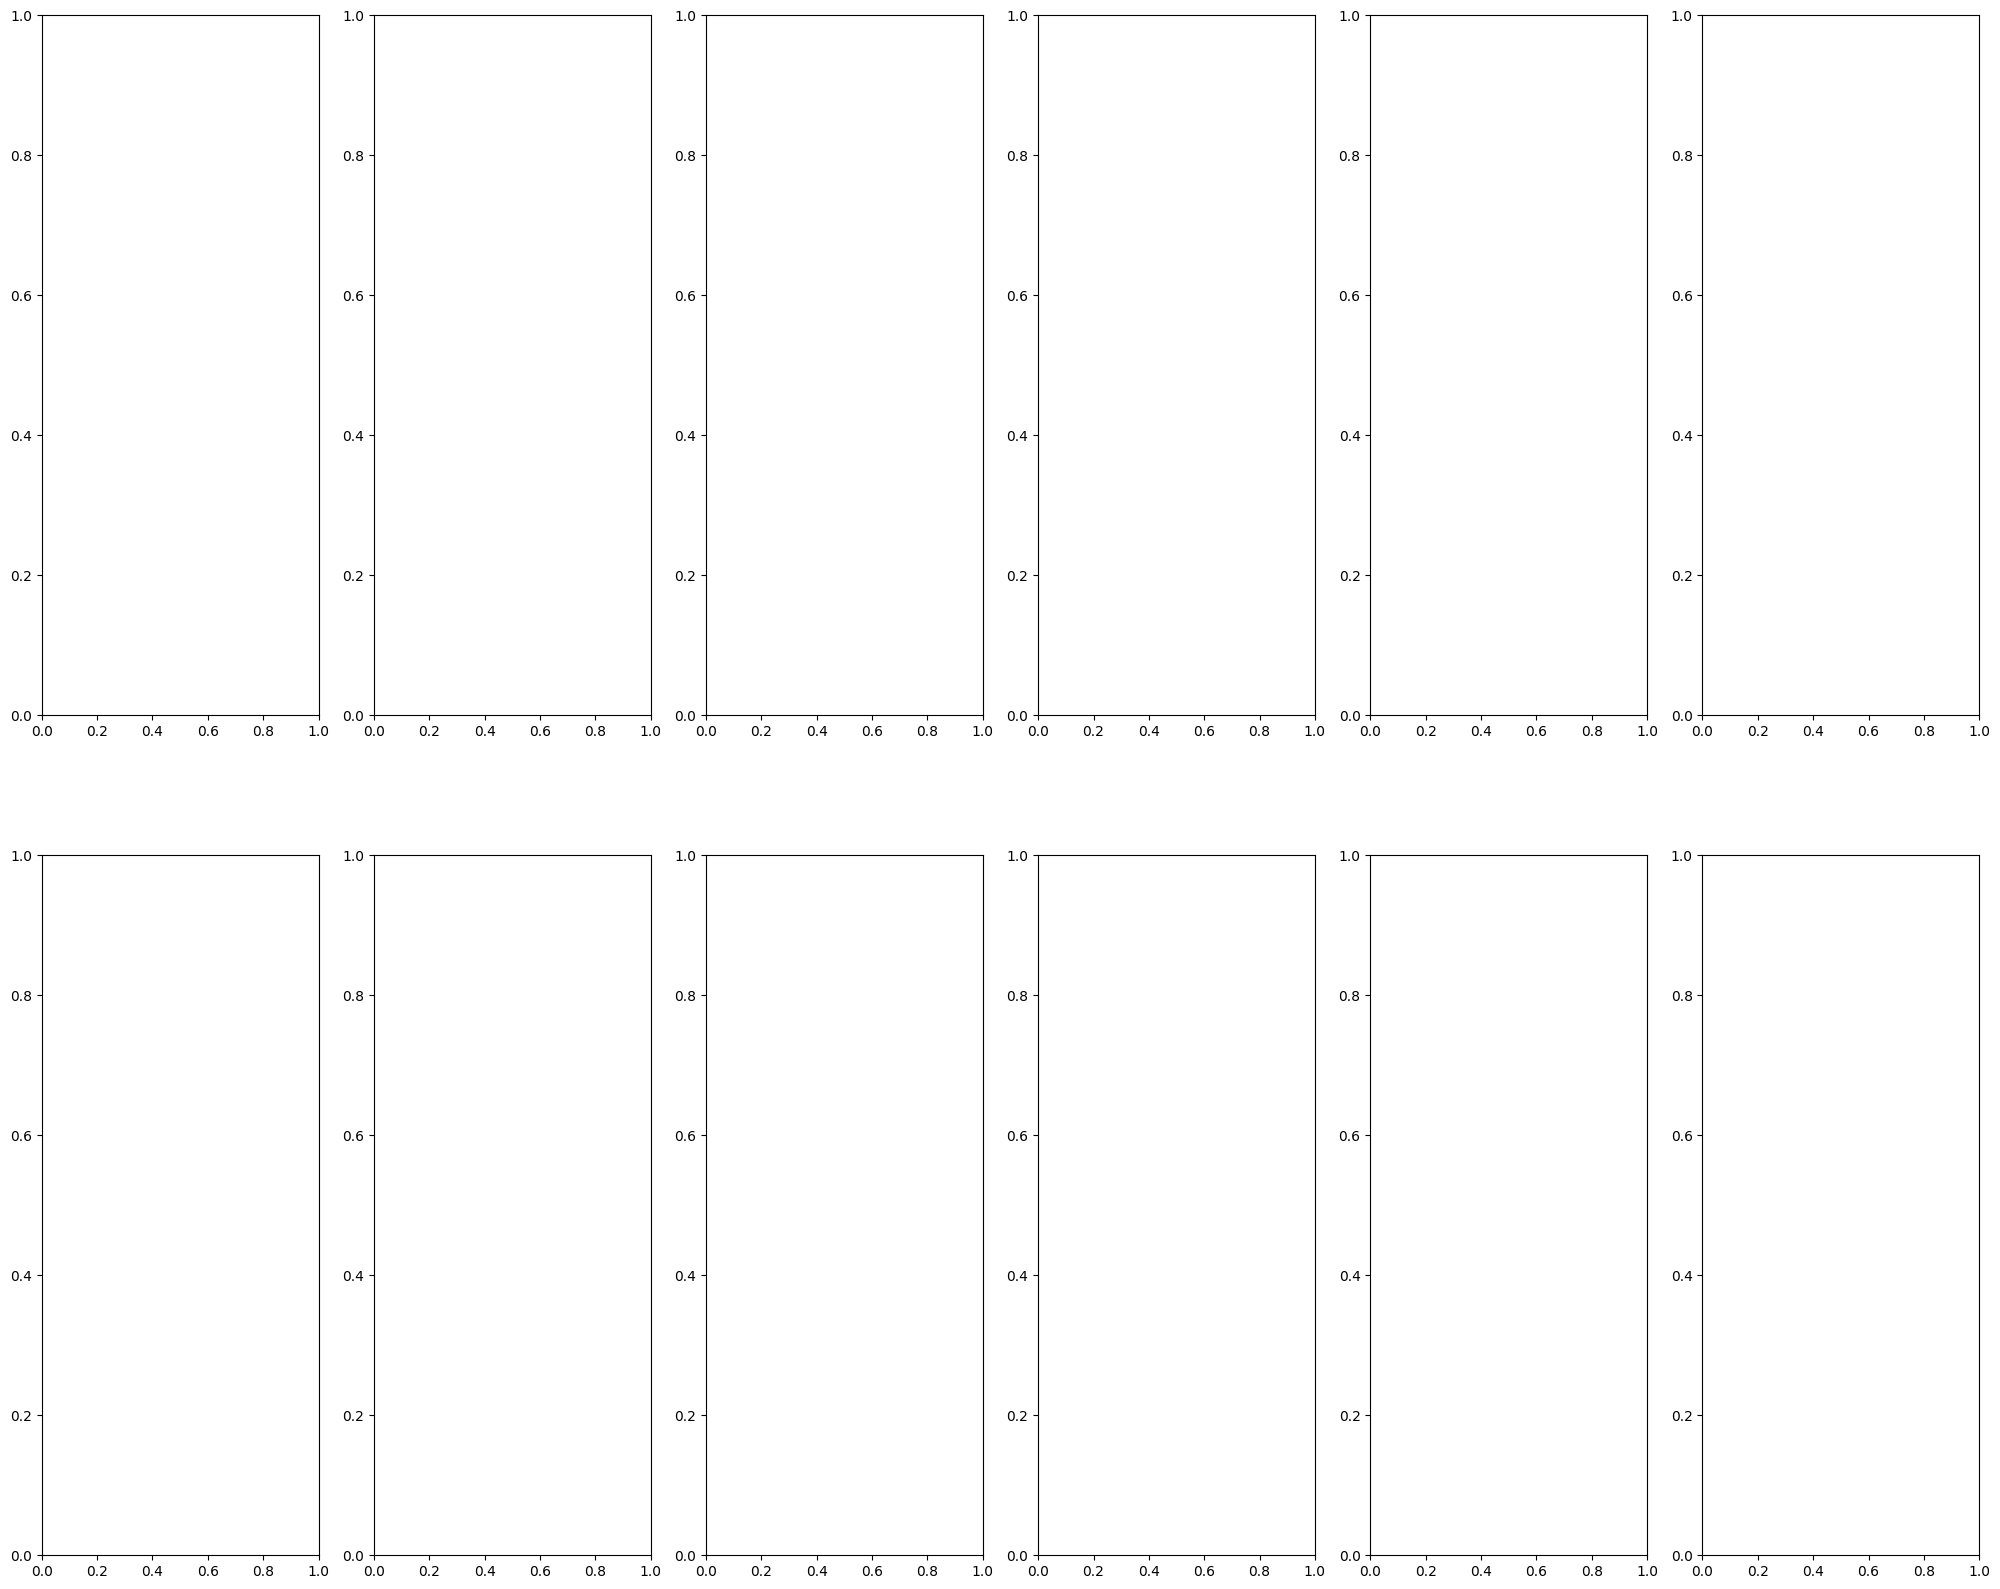

In [8]:
# --- SET UP ---
# Split data into label and data
label = data['label']
data_nolabel = data.drop('label', axis=1)

# K-fold outer cross-validation
k_folds = 5
cv_outer = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42) #random_state ensures same shuffling pattern

# K-fold inner cross-validation
n_folds = 5
cv_inner = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42) #shuffle ensures no bias by ordered data

# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', random_state=42), # class weight balanced adjusts the weights of the classes because classes are unbalanced
    "SGDClassifier": SGDClassifier(class_weight='balanced', random_state=42),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "SVC": SVC(class_weight='balanced', random_state=42),
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', random_state=42)}

# Hyperparameters per classifier
param_grids = {
    "LogisticRegression": [
        {"C": [0.01, 0.1, 1, 10], # Regularization strength
         "penalty": ['l2'], # Regularization type
         "solver": ['lbfgs']}, # Optimization algorithm
        {"C": [0.01, 0.1, 1, 10],
         "penalty": ['l2', 'l1'],
         "solver": ['liblinear']}],
    "SGDClassifier": {
        "loss": ['hinge', 'log_loss', 'modified_huber'],  # Loss function
        "penalty": ['l2', 'l1'],  # Regularization type
        "alpha": [0.001, 0.01, 0.1]},  # Regularization amount
    "KNeighborsClassifier": {
        "n_neighbors": [2, 3, 5, 7, 9],  # Number of neighbors
        "weights": ['uniform', 'distance']},  # Weighting scheme
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 7, 9, 11],  # Tree depth
        "min_samples_split": [2, 5, 10, 15]},  # Minimum samples for split
    "SVC": {
        "kernel": ['linear', 'rbf', 'poly'],  # Kernel type
        "degree": [2, 3, 5],  # Polynomial degree
        "C": [0.1, 1, 10]},  # Regularization parameter
    "RandomForestClassifier": {
        "n_estimators": [1, 5, 10, 50],  # Number of trees
        "max_depth": [3, 5, 7, 9, 11]}}  # Tree depth

f1_threshold = 0.5
f1_test = []
precision_recall_list = []
fold_num = 1

# --- OUTER cross validation loop ---
for train1_index, test_index in cv_outer.split(data_nolabel, label):
    print(f"Starting outer fold {fold_num}")
    fold_num += 1

    # Split data into first train and test sets
    X_train1, X_test = data_nolabel.iloc[train1_index], data_nolabel.iloc[test_index]
    y_train1, y_test = label.iloc[train1_index], label.iloc[test_index]

    ### Pre-processing
    ## data checks
    # Check which label is normal and abnormal
    if sum(data['label']) > len(data) / 2: # Biggest class is 'normal'
        normal_label = 0
        abnormal_label = 1
    else:
        # Biggest class is 'abnormal'
        normal_label = 1
        abnormal_label = 0

    # Check for normal distribution of features
    p_values = X_train1.apply(lambda col: normaltest(col)[1]) # test normality of each feature and get p-value
    non_normal_features = (p_values < 0.05).sum() # count number of features with p-value < 0.05 (not normally distributed)

    ## Missing data handling
    # Change None into median of training data
    data_train_clean = X_train1.copy()
    imputer = SimpleImputer(strategy='median')
    data_train_clean[:] = imputer.fit_transform(data_train_clean)

    ## Scaling
    # Find outliers in data
    def count_outliers(df):
      '''function to detect outliers in data'''
      Q1 = df.quantile(0.25)
      Q3 = df.quantile(0.75)
      IQR = Q3 - Q1 # Spread of the middle 50% of data
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outliers = ((df < lower_bound) | (df > upper_bound)).sum()
      return outliers

    outlier_counts = count_outliers(data_train_clean)
    mean_outliers = outlier_counts.mean()
    features_with_many_outliers = (outlier_counts > 0.1 * len(data_train_clean.index)).sum()

    # MinMaxScaler chosen
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_train_clean)

    ## Feature selection
    # 1. Univariate statistical testing: ANOVO f-test
    # Number of features where p < 0.05
    f_scores, p_values = f_classif(data_scaled, y_train1)
    k_best = np.sum(p_values < 0.05) # Only features with p_value < 0.05

    selector = SelectKBest(f_classif, k=k_best)
    data_selected = selector.fit_transform(data_scaled, y_train1)
    print(f'Univariatiate statistical feature selection performed: {k_best} features selected.')

    # 2. Dimensionality reduction with PCA
    # Number of components where variance ≥99%
    pca_full = PCA().fit(data_selected)
    explained_var = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    pca_components = np.argmax(cumulative_var >= 0.99) + 1   # find number of components that explain at least 99% of the variance

    pca = PCA(n_components=pca_components) # Reduce to features so that variance > 0.99
    data_final_selected = pca.fit_transform(data_selected)
    print(f'PCA feature selection performed: {pca_components} features left.')

    # initialize for storage
    clf_params = {}
    auc_scores = {}
    f1_scores = {}
    ensemble_classifiers = []
    ensemble_fold_indices = []

    inner_fold_num = 1

    # --- INNER cross validation loop ---
    for train_index, val_index in cv_inner.split(data_final_selected, y_train1):
        print(f"Starting inner fold {inner_fold_num}")

        # Split data into train and validation sets
        X_train, X_val = data_final_selected[train_index], data_final_selected[val_index]
        y_train, y_val = y_train1.iloc[train_index], y_train1.iloc[val_index]

        # Store classifiers for ensembling
        fold_classifiers = []

        # Create learning curve plots
        i=0
        fig, axes = plt.subplots(2, len(classifiers), figsize=(25, 20))

        # --- classifier loop ---
        for clf_name, clf in classifiers.items():
          # initialize list to store results
          clf_params.setdefault(clf_name, [])
          auc_scores.setdefault(clf_name, [])
          auc_scores.setdefault('VotingEnsembleHard', [])
          f1_scores.setdefault(clf_name, [])
          f1_scores.setdefault('VotingEnsembleHard', [])

          ## Hyperparameter optimization
          # find best hyperparams for current classifier
          grid_search = GridSearchCV(clf, param_grids[clf_name], cv=cv_inner, n_jobs=-1, scoring='f1')
          grid_search.fit(X_train, y_train)
          clf = grid_search.best_estimator_    # get best estimator
          clf_params[clf_name].append(clf)     # store best estimator
          print(f"Best parameters for {clf_name}: {grid_search.best_params_}")

          ### Visualisation
          ## Calculate AUC-score
          y_pred = clf.predict(X_val)
          if hasattr(clf, "predict_proba"):
              y_score = clf.predict_proba(X_val)[:, 1]
          elif hasattr(clf, "decision_function"):
              y_score = clf.decision_function(X_val)
          else:
              y_score = y_pred  # fallback if neither method is available

          auc = roc_auc_score(y_val, y_score)
          auc_scores[clf_name].append(auc)  # Store AUC for this classifier

          ## Calculate F1-score for this classifier
          f1 = f1_score(y_val, y_pred)
          f1_scores[clf_name].append(f1)  # Store F1-score for this classifier

          # Calculate ROC
          fpr, tpr, thresholds = roc_curve(y_val, y_score)

          # Plot ROC curve for each classifier
          axes[0,i].plot(fpr, tpr, label=f'{clf_name} (AUC = {auc:.2f})')
          axes[0,i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
          axes[0,i].set_xlabel('False Positive Rate')
          axes[0,i].set_ylabel('True Positive Rate')
          axes[0,i].set_title(f'ROC Curve - {clf_name}')
          axes[0,i].legend()

          ## Learning curves
          train_sizes, train_scores, val_scores = \
            learning_curve(clf, X_train, y_train,
                            cv=cv_inner,n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

          # calculate mean and std of training and validation scores
          train_scores_mean = np.mean(train_scores, axis=1)
          train_scores_std = np.std(train_scores, axis=1)
          val_scores_mean = np.mean(val_scores, axis=1)
          val_scores_std = np.std(val_scores, axis=1)

          # plot learning curve
          axes[1,i].set_title(f'Learning Curve - {clf_name}')
          axes[1,i].set_ylim(0.3, 1.01) # Adjust ylim as needed
          axes[1,i].set_xlabel("Training examples")
          axes[1,i].set_ylabel("Score")
          axes[1,i].grid()
          axes[1,i].fill_between(train_sizes,train_scores_mean - train_scores_std,
                              train_scores_mean + train_scores_std,alpha=0.1,color="r")
          axes[1,i].fill_between(train_sizes,val_scores_mean - val_scores_std,val_scores_mean + val_scores_std,alpha=0.1,color="g")
          axes[1,i].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
          axes[1,i].plot(train_sizes, val_scores_mean, "o-", color="g",
                      label="Cross-validation score")
          axes[1,i].legend(loc="best")

          i += 1

          ## Selection for ensembling based on f1-score value
          if f1 > f1_threshold: # Store high scoring classifiers
            fold_classifiers.append((clf_name, clf))

      # Out of classifier loop, still in cross-validation loop
      ## Ensembling
        if len(fold_classifiers) > 1:  # Cannot ensemble 1 classifier
            voting_ensemble = VotingClassifier(estimators=fold_classifiers, voting='hard')
            voting_ensemble.fit(X_train, y_train)
            y_pred = voting_ensemble.predict(X_val)
            f1 = f1_score(y_val, y_pred)
            f1_scores['VotingEnsembleHard'].append(f1)
            ensemble_classifiers.append(voting_ensemble)
        else:
            clf_names = [name for name, _ in fold_classifiers]
            print(f"Only {len(fold_classifiers)} classifier(s) above F1 threshold in inner fold {inner_fold_num}: {clf_names}. Skipping ensembling.")

        ensemble_fold_indices.append(inner_fold_num)
        inner_fold_num += 1

    # Out of cross-validation loop
    ## Select best ensembling model
    if f1_scores['VotingEnsembleHard']:
        best_f1 = max(f1_scores['VotingEnsembleHard'])
        best_idx = f1_scores['VotingEnsembleHard'].index(best_f1)
        best_ensemble = ensemble_classifiers[best_idx]
        best_inner_fold = ensemble_fold_indices[best_idx]
        print(f'Best ensemble model created in inner fold {best_inner_fold} with F1 score {best_f1:.4f}')
    else:
        best_ensemble = None
        best_f1, best_idx, best_clf_name = max(
            [(value, i, key) for key, values in f1_scores.items() for i, value in enumerate(values)],
            key=lambda item: item[0])
        best_clf = clf_params[best_clf_name][best_idx]
        print(f'Best individual classifier: {best_clf_name} from inner fold {best_idx + 1} with F1 score {best_f1:.4f}')

    ## Evaluate model on test data
    # Change None into median of train data
    data_test_clean = X_test.copy()
    data_test_clean[:] = imputer.transform(data_test_clean)
    # Scaling testdata
    X_test_scaled = scaler.transform(data_test_clean)
    # Feature selection
    X_test_selected = selector.transform(X_test_scaled) # 1. univariate
    X_test_final_selected = pca.transform(X_test_selected) # 2. pca

    # Ensembling
    if best_ensemble:  # if ensemble is created, use for prediction
        y_pred_test = best_ensemble.predict(X_test_final_selected)
        f1_test_fold = f1_score(y_test, y_pred_test)
        f1_test.append(f1_test_fold)
        print(f"Final ensemble model used — F1-score on test data: {f1_test_fold:.4f}")

        print("Ensemble includes the following classifiers:")
        for name, estimator in best_ensemble.estimators:
            print(f" - {name}: {estimator}")
    else:  # otherwise use best individual classifier for prediction
        y_pred_test = best_clf.predict(X_test_final_selected)
        f1_test_fold = f1_score(y_test, y_pred_test)
        f1_test.append(f1_test_fold)
        print(f"Final individual model ({best_clf_name}) used — F1-score on test data: {f1_test_fold:.4f}")

    ## Final evaluation
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
    # Calculate Average Precision (AP)
    average_precision = average_precision_score(y_test, y_pred_test)
    # Add to list
    precision_recall_data = (precision, recall, average_precision)
    precision_recall_list.append(precision_recall_data)


## Out of outer cross-validation loop
Visualisation

In [ ]:
# Visualize f-scores for univariate feature selection
sorted_scores = np.sort(f_scores)[::-1]  # Sort on descending
plt.figure(figsize=(10,5))
plt.plot(sorted_scores[:2000])
plt.axvline(x=k_best, color='r', linestyle='--', label=f'{k_best} features selected')
plt.title('Sorted ANOVA F-scores of features')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.legend()
plt.grid(True)
plt.show()

# Plot variance for PCA
plt.figure(figsize=(10,5))
plt.plot(cumulative_var, marker='o', label='Cumulative variance')
plt.axhline(y=0.99, color='r', linestyle='--', label='99%') # earlier defined 99% variance threshold for PCA
plt.axvline(x=pca_components, color='g', linestyle='--', label=f'{pca_components} components')
plt.title('Cumulative variance per PCA-component')
plt.xlabel('Number of PCA-components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.grid(True)
plt.show()

# Visualize new features with t-SNE
tsne = TSNE(n_components=2, random_state=42) # Reduce to 2 dimensions for plotting
data_tsne = tsne.fit_transform(data_final_selected)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[y_train1 == 0, 0], data_tsne[y_train1 == 0, 1], label='Label 0', marker='o')  # Plot points for label 0
plt.scatter(data_tsne[y_train1 == 1, 0], data_tsne[y_train1 == 1, 1], label='Label 1', marker='x')  # Plot points for label 1
plt.legend()  # Add a legend to identify the labels
plt.title('t-SNE Visualization of Selected Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Performance estimate

In [ ]:
f1_test_mean = np.mean(f1_test)
print(f"mean F1-score on testdata: {f1_test_mean}")

# confusion matrix
metrics.confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(y_test, y_pred_test),
                              display_labels=np.unique(y_test)) # Changed to unique labels in filtered_label_test
disp.plot()
plt.show()

# # Plot Precision-Recall curve

all_precisions = []
all_recalls = []
all_average_precisions = []
fig, ax = plt.subplots()
for i, (precision, recall, average_precision) in enumerate(precision_recall_list):
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_average_precisions.append(average_precision)
    # Plot Precision-Recall curve
    display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    display.plot(ax=ax, name=f"Fold {i+1}", linestyle='--')  # Plot on the same axes with a label for each fold

display = PrecisionRecallDisplay(precision=np.mean(all_precisions, axis=0), recall=np.mean(all_recalls, axis=0), average_precision=np.mean(all_average_precisions))
display.plot(ax=ax, name=f"All Folds", linestyle='-')  # Plot on the same axes with a label for each fold
plt.title('Precision-Recall curve for All Folds')
plt.show()